# Le but de ce projet est de construire un modèle permettant de détecter un incendie sur un flux vidéo

# Importation des librairies

In [47]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np 
from PIL import Image

# On définit les chemins d'accès vers les datasets

In [72]:
train_dir = "/Users/avicenne/Documents/python/fire_forest_project/fire_dataset/Train_Data"
validation_dir = "/Users/avicenne/Documents/python/fire_forest_project/fire_dataset/Validation_Data"
test_dir = "/Users/avicenne/Documents/python/fire_forest_project/fire_dataset/Test_Data"


# On définit les générateurs de batch d'images

In [75]:
# On rescale les images 1./255
train_datagen = ImageDataGenerator(rescale= 1./255)
validation_datagen = ImageDataGenerator(rescale= 1./255)
#test_datagen = ImageDataGenerator(rescale= 1./255)

# On utilise des data generator

train_generator = train_datagen.flow_from_directory(
        train_dir, #répertoire données d'apprentissage
        target_size=(150, 150), # On resized resized à 150x150
        batch_size=20,  #batch image de taille 20
        class_mode='binary' # on a bien deux classes
)


validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary') 

test_generator = test_datagen.flow_from_directory(
        test_dir, #répertoire données d'apprentissage
        target_size=(150, 150), # On resized resized à 150x150
        batch_size=20,  #batch image de taille 20
        class_mode='binary' # on a bien deux classes
)



Found 762 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.


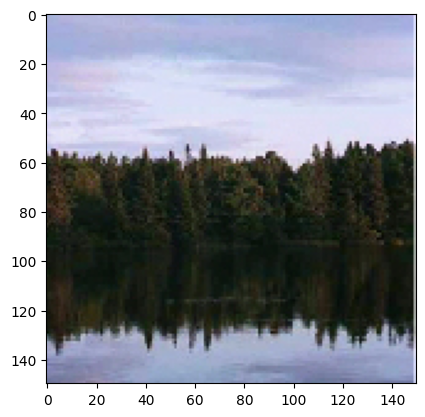

In [77]:
## on vérifie que les images sont correctement lu
plt.imshow(test_generator[1][0][2])

# Création du modèle pour distinguer un feu de forêt

In [57]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPool2D(2))
model . add ( layers . Flatten () )
model.add(layers.Dropout(0.5))
model . add ( layers . Dense ( units =512 , activation = "relu" ) )
model . add ( layers . Dense ( units =1 , activation = "sigmoid" ) )

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [58]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10)

Epoch 1/20
10/10 [==============================] - 8s 802ms/step - loss: 0.6302 - accuracy: 0.7650 - val_loss: 0.5378 - val_accuracy: 0.7000
Epoch 2/20
10/10 [==============================] - 8s 783ms/step - loss: 0.2602 - accuracy: 0.8250 - val_loss: 0.3336 - val_accuracy: 0.8250
Epoch 3/20
10/10 [==============================] - 8s 794ms/step - loss: 0.2589 - accuracy: 0.9050 - val_loss: 0.2757 - val_accuracy: 0.9550
Epoch 4/20
10/10 [==============================] - 7s 673ms/step - loss: 0.2124 - accuracy: 0.9200 - val_loss: 0.2220 - val_accuracy: 0.9150
Epoch 5/20
10/10 [==============================] - 8s 773ms/step - loss: 0.1576 - accuracy: 0.9400 - val_loss: 0.2452 - val_accuracy: 0.9300
Epoch 6/20
10/10 [==============================] - 7s 700ms/step - loss: 0.1424 - accuracy: 0.9450 - val_loss: 0.2367 - val_accuracy: 0.9600
Epoch 7/20
10/10 [==============================] - 8s 812ms/step - loss: 0.2508 - accuracy: 0.9000 - val_loss: 0.2216 - val_accuracy: 0.9200
Epoch 

In [59]:
#image à prdire à mettre au format (150,150, 3)

forest = cv.imread("/Users/avicenne/Documents/python/fire_forest_project/forest.jpeg")
fireforest = cv.imread("/Users/avicenne/Documents/python/fire_forest_project/fireforest.jpeg")

print(forest.shape)
fireforest.resize(1,150,150,3)
forest.resize(1,150,150,3)
forest.shape

(183, 275, 3)


(1, 150, 150, 3)

# On vérifie que notre modèle est précis

In [60]:
result = ["fire", "no fire"]
result[int(model.predict(fireforest))]

1/1 [==============================] - 0s 146ms/step


'fire'

In [61]:
result = ["fire", "no fire"]
result[int(model.predict(forest))]

1/1 [==============================] - 0s 34ms/step


'no fire'

# Récupération d'un mouvement sur vidéo 

On récupère un flux vidéo, on repère les mouvements et on les entre dans notre modèle pour savoir s'il s'agit d'un feu de forêt.

In [79]:
    
def detect(model, path_to_video):
    #cap = cv2.VideoCapture(0)

    ## on lit la vidéo en question
    cap = cv2.VideoCapture(path_to_video)

    detect = ["forest fire", "not forest fire"]

    while True:
        ret, frame1 = cap.read()
        ret, frame2 = cap.read()

        ## détection d'un mouvement sur l'image

        diff = cv2.absdiff(frame1,frame2)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh[1], None, iterations = 3)
        contours, hierch = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    ###on récupère tous les éléments qui sont détéctés comme étant en mouvement, et on dessine un rectangle autour
    ### de plus on va les analyser pour savoir s'il s'agit d'un feu de forêt ou non

        for contour in contours:
            (x,y,z,w) = cv2.boundingRect(contour)
            if cv2.contourArea(contour)<500:   #taille de l'élément en mouvement
                continue

    ### on récupère l'objet en mouvement
            img = np.asarray([frame1[x : (x+z), y:(y+w)]])
            if img.shape[1] >100 and img.shape[2] >100 :
                cv2.rectangle(frame1, (x,y), (x+z, y+w), (0,255,0),2)

                print(type(img))

                img = np.resize(img, (1,150,150,3))
                print(type(img), img.shape)

                ## on tente de prédire s'il s'agit d'un feu de forêt
                pred = model.predict(img)

    ### on écrit sur la vidéo s'il s'agit d'un feu ou non
                cv2.putText(frame1, detect[int(pred)], (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        cv2.imshow("feed", frame1)
        if cv2.waitKey(1) == 27: 
            break  # esc to quit

    cv2.destroyAllWindows()
    


In [4]:
import cv2

vid = cv2.VideoCapture(0)

while True:
    ret, frame1 = vid.read()
    cv2.imshow("feed", frame1)
    if cv2.waitKey(1) == 27: 
        break  # esc to quit
    
cv2.destroyAllWindows()


# Utilisation du fine tuning sur VGG16

In [62]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [63]:

finetune = models.Sequential()
finetune.add(conv_base)
finetune.add(layers.Flatten())
finetune.add(layers.Dense(256, activation='relu'))
finetune.add(layers.Dense(1, activation='sigmoid'))

finetune.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


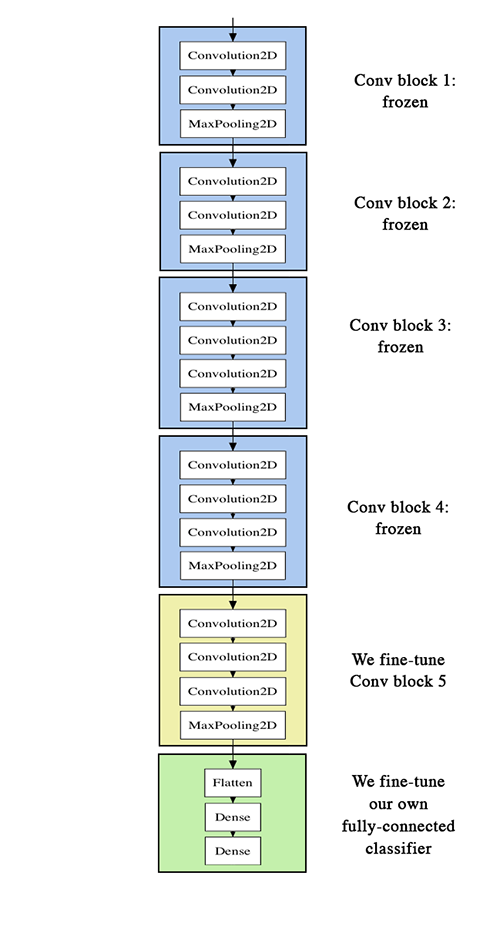

# On va geler les couches de convolutions sauf le block5

In [64]:

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [66]:
finetune.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = finetune.fit(
      train_generator,
      steps_per_epoch=20,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/20
20/20 [==============================] - 71s 4s/step - loss: 0.3303 - acc: 0.8500 - val_loss: 0.3665 - val_acc: 0.8439
Epoch 2/20
20/20 [==============================] - 48s 2s/step - loss: 0.2545 - acc: 0.8979
Epoch 3/20
20/20 [==============================] - 50s 2s/step - loss: 0.1913 - acc: 0.9350
Epoch 4/20
20/20 [==============================] - 51s 3s/step - loss: 0.1734 - acc: 0.9300
Epoch 5/20
20/20 [==============================] - 51s 3s/step - loss: 0.1420 - acc: 0.9525
Epoch 6/20
20/20 [==============================] - 52s 3s/step - loss: 0.1014 - acc: 0.9750
Epoch 7/20
20/20 [==============================] - 50s 2s/step - loss: 0.1038 - acc: 0.9660
Epoch 8/20
20/20 [==============================] - 52s 3s/step - loss: 0.0792 - acc: 0.9895
Epoch 9/20
20/20 [==============================] - 54s 3s/step - loss: 0.0561 - acc: 0.9850
Epoch 10/20
20/20 [==============================] - 53s 3s/step - loss: 0.0693 - acc: 0.9825
Epoch 11/20
20/20 [=============

In [67]:
finetune.save_weights('/Users/avicenne/Documents/python/fire_forest_project/fire_detect_fine_tuning_VGG16.h5')

In [78]:
test_loss, test_acc = finetune.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 100s 2s/step - loss: 0.5642 - acc: 0.8040
test acc: 0.8040000200271606


In [ ]:
detect(model, path_to_video)